<a href="https://colab.research.google.com/github/my-tech123/Assignment-1-energy/blob/main/walmart_regression_notebook_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Analysis — Linear, Ridge, Lasso, and Bayesian Regression for Walmart Sales Forecasting
**Dataset:** `Walmart.csv` (Kaggle: yasserh/walmart-dataset)  
**Objective:** Predict weekly sales (`Weekly_Sales`) and compare Linear, Ridge, Lasso, and Bayesian regressions using R², RMSE, and MAE.  
**Notebook style:** Educational — step-by-step explanations, visualizations, and code.


In [11]:
# Install required packages (uncomment pip lines if running on Colab)
# !pip install -q scikit-learn pandas matplotlib seaborn nbformat joblib kaggle

import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
print('Libraries loaded.')

Libraries loaded.


## 1) Download dataset
**Two options:**

- **Browser:** Go to the Kaggle page: `https://www.kaggle.com/datasets/yasserh/walmart-dataset` → Download → extract `Walmart.csv` into the notebook working directory.
- **Kaggle CLI (Colab/Jupyter):** If you have `kaggle.json` (API token), place it in `~/.kaggle/kaggle.json`, then run the cell below to download automatically.


In [12]:
# Kaggle CLI download (uncomment and run if you have kaggle.json configured)
# !mkdir -p ~/.kaggle
# !cp /path/to/kaggle.json ~/.kaggle/  # adjust path if uploading in Colab
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d yasserh/walmart-dataset -p ./data --unzip

# If you've manually downloaded and placed Walmart.csv in working dir, load it directly:
import os, pandas as pd
if os.path.exists('Walmart.csv'):
    path = 'Walmart.csv'
elif os.path.exists('Walmart.csv'):
    path = 'Walmart.csv'
else:
    path = None
    print('Walmart.csv not found in working directory. Please download from Kaggle and upload it to the notebook.')

if path:
    df = pd.read_csv(path, parse_dates=['Date'])
    print('Loaded', path)
    display(df.head())

Loaded Walmart.csv


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## 2) Exploratory Data Analysis (EDA)
We'll inspect the structure, missing values, target distribution, and some seasonal patterns.

Shape: (6435, 8)

Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

Missing values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


,Weekly_Sales
count,6.435000e+03
mean,1.046965e+06
std,5.643666e+05
min,2.099862e+05
25%,5.533501e+05
50%,9.607460e+05
75%,1.420159e+06
max,3.818686e+06


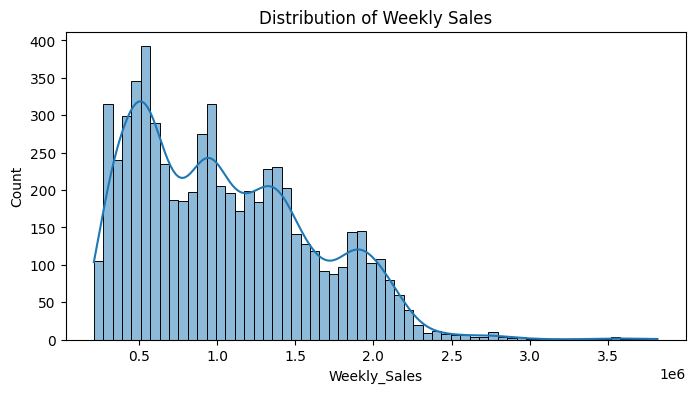

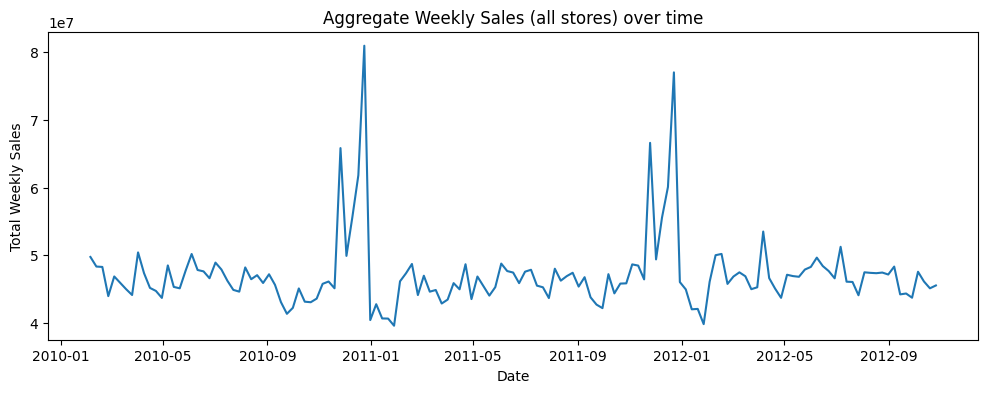

In [13]:
# Basic EDA (run after loading df)
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nMissing values:')
print(df.isnull().sum())

# Convert Date if not parsed
if df['Date'].dtype == 'O':
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Quick stats for Weekly_Sales
display(df['Weekly_Sales'].describe())

# Plot Weekly_Sales distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Weekly_Sales'], bins=60, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly_Sales')
plt.show()

# Time series plot for total weekly sales (aggregate across stores)
agg = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(agg['Date'], agg['Weekly_Sales'])
plt.title('Aggregate Weekly Sales (all stores) over time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

## 3) Feature engineering
Create date-based features, encode holiday flag, and aggregate/store-level options. We'll build a model that predicts `Weekly_Sales` using store-level and external features.

In [14]:
# Feature engineering
data = df.copy()

# Date features
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['week'] = data['Date'].dt.isocalendar().week.astype(int)
data['dayofweek'] = data['Date'].dt.dayofweek

# Holiday_Flag is already present — ensure numeric
if 'Holiday_Flag' in data.columns:
    data['Holiday_Flag'] = data['Holiday_Flag'].astype(int)

# Select features: use a mix of store info and external variables
features = ['Store','Dept','IsHoliday','Temperature','Fuel_Price','CPI','Unemployment']
# NOTE: the dataset has 'IsHoliday' column; map boolean-like if necessary
if 'IsHoliday' in data.columns:
    data['IsHoliday'] = data['IsHoliday'].astype(int)

# If Temperature column name differs, attempt alternatives
alt_temps = [c for c in data.columns if 'temp' in c.lower()]
if 'Temperature' not in data.columns and alt_temps:
    data['Temperature'] = data[alt_temps[0]]

# Drop rows with missing values in our chosen columns (small cleanup)
data = data.dropna(subset=['Weekly_Sales'] + [c for c in features if c in data.columns])

# Aggregate at Store-week level
store_week = data.groupby(['Date','Store','Holiday_Flag']).agg({
    'Weekly_Sales':'sum',
    'Temperature':'mean' if 'Temperature' in data.columns else (alt_temps[0] if alt_temps else 'mean'),
    'Fuel_Price':'mean' if 'Fuel_Price' in data.columns else 'mean',
    'CPI':'mean' if 'CPI' in data.columns else 'mean',
    'Unemployment':'mean' if 'Unemployment' in data.columns else 'mean'
}).reset_index()

# Recreate date features on aggregated df
store_week['year'] = store_week['Date'].dt.year
store_week['month'] = store_week['Date'].dt.month
store_week['week'] = store_week['Date'].dt.isocalendar().week.astype(int)
store_week['dayofweek'] = store_week['Date'].dt.dayofweek

store_week.rename(columns={'Weekly_Sales':'Weekly_Sales_Store'}, inplace=True)
display(store_week.head())

,Date,Store,Holiday_Flag,Weekly_Sales_Store,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,dayofweek
0,2010-02-05,1,0,1643690.90,42.31,2.572,211.096358,8.106,2010,2,5,4
1,2010-02-05,2,0,2136989.46,40.19,2.572,210.752605,8.324,2010,2,5,4
2,2010-02-05,3,0,461622.22,45.71,2.572,214.424881,7.368,2010,2,5,4
3,2010-02-05,4,0,2135143.87,43.76,2.598,126.442065,8.623,2010,2,5,4
4,2010-02-05,5,0,317173.10,39.70,2.572,211.653972,6.566,2010,2,5,4


## 4) Prepare training and test sets (time-based split)
We'll sort by date and use the last 20% of time for testing to avoid leakage.

In [15]:
# Sort by date and create train-test temporal split
df_model = store_week.sort_values('Date').reset_index(drop=True)
train_size = int(len(df_model)*0.8)
train = df_model.iloc[:train_size].copy()
test = df_model.iloc[train_size:].copy()

target = 'Weekly_Sales_Store'
# Build feature columns (include Store as small set)
feature_cols = ['Store','Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','year','month','week','dayofweek']

# One-hot encode 'Store' (keep top N stores to limit dimensionality)
top_stores = train['Store'].value_counts().nlargest(30).index.tolist()
def map_store(s): return s if s in top_stores else -1
train['Store_small'] = train['Store'].apply(map_store)
test['Store_small'] = test['Store'].apply(map_store)

train = pd.get_dummies(train, columns=['Store_small'], prefix='Store')
test = pd.get_dummies(test, columns=['Store_small'], prefix='Store')

# Align columns
train, test = train.align(test, join='outer', axis=1, fill_value=0)

# Prepare X/y
exclude = ['Date','Weekly_Sales_Store','Store']
X_train = train[[c for c in train.columns if c not in exclude]]
y_train = train['Weekly_Sales_Store']
X_test = test[[c for c in test.columns if c not in exclude]]
y_test = test['Weekly_Sales_Store']

# Scale numeric features
num_cols = ['Temperature','Fuel_Price','CPI','Unemployment','year','month','week','dayofweek']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in num_cols:
    if col in X_train.columns:
        X_train[col] = scaler.fit_transform(X_train[[col]])
        X_test[col] = scaler.transform(X_test[[col]])
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

X_train shape: (5148, 40) X_test shape: (1287, 40)


## 5) Train models
Train Linear, Ridge, Lasso, and Bayesian regressions on the prepared data.

In [16]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Bayesian Regression': BayesianRidge()
}

fitted = {}
preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fitted[name] = model
    preds[name] = y_pred
    print(f'{name} trained.')

Linear Regression trained.
Ridge Regression trained.
Lasso Regression trained.
Bayesian Regression trained.


## 6) Evaluation
Compute R², RMSE, and MAE for each model and present a results table.

In [17]:
results = []
for name, y_pred in preds.items():
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append([name, r2, rmse, mae])

results_df = pd.DataFrame(results, columns=['Model','R2','RMSE','MAE'])
results_df[['R2','RMSE','MAE']] = results_df[['R2','RMSE','MAE']].round(4)
results_df.sort_values('R2', ascending=False, inplace=True)
display(results_df)

,Model,R2,RMSE,MAE
1,Ridge Regression,0.6258,326997.8753,214911.5014
3,Bayesian Regression,0.6258,327013.0028,214986.5705
0,Linear Regression,0.6257,327066.6498,215178.0825
2,Lasso Regression,0.6257,327066.2817,215175.0616


## 7) Coefficients / Feature importance
Visualize coefficients for linear-family models and inspect which features matter.

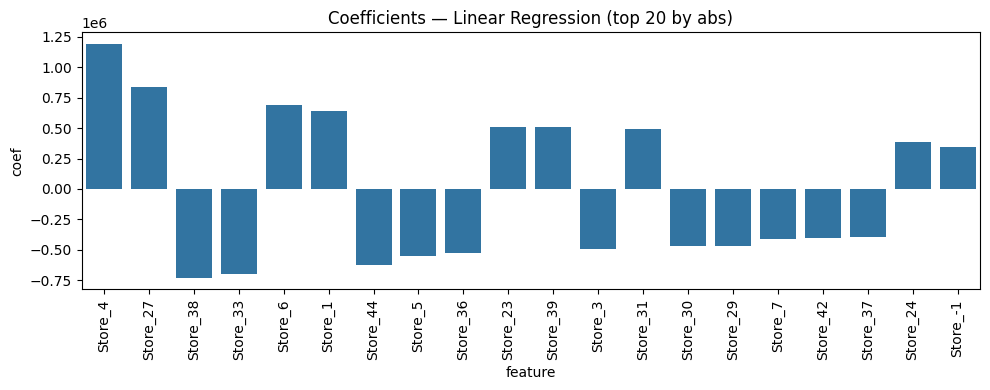

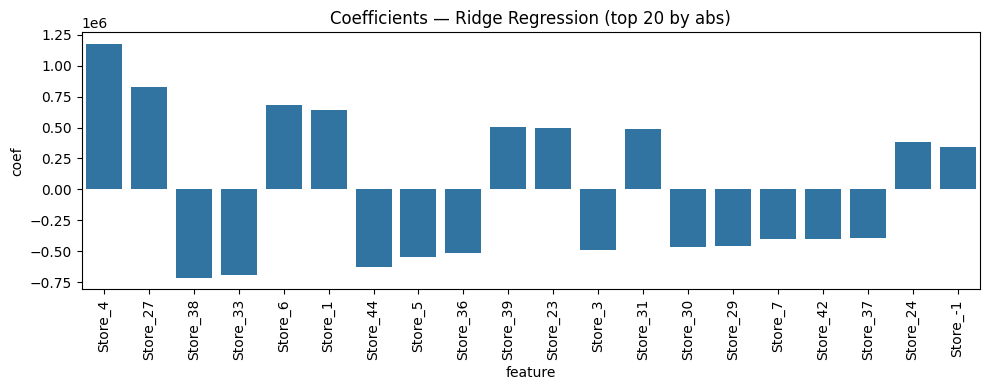

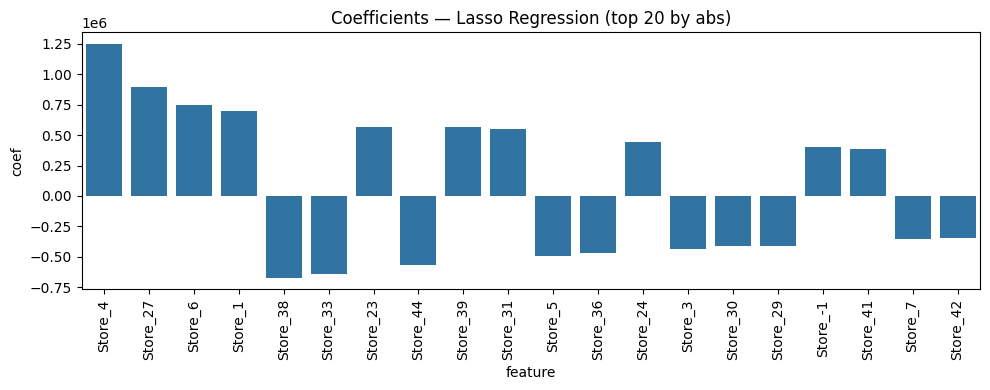

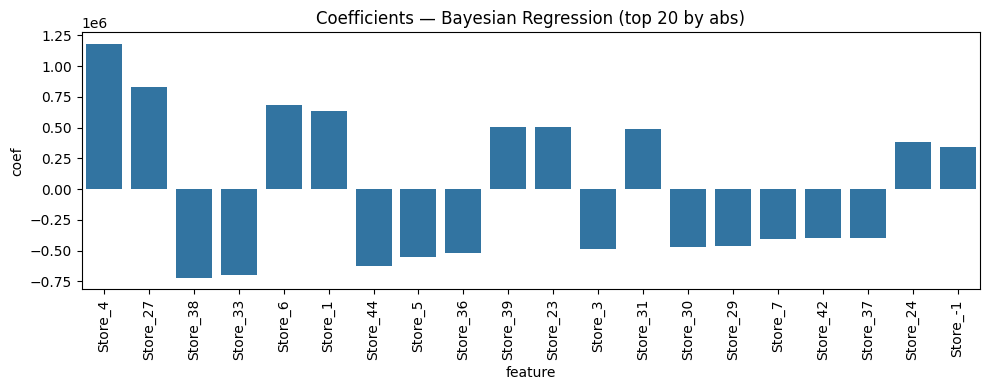

In [18]:
feature_names = X_train.columns.tolist()
for name, model in fitted.items():
    if hasattr(model, 'coef_'):
        coefs = model.coef_
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
        coef_df['abs'] = coef_df['coef'].abs()
        coef_df = coef_df.sort_values('abs', ascending=False).head(20)
        plt.figure(figsize=(10,4))
        sns.barplot(data=coef_df, x='feature', y='coef')
        plt.xticks(rotation=90)
        plt.title(f'Coefficients — {name} (top 20 by abs)')
        plt.tight_layout()
        plt.show()

## 8) Predictions: Actual vs Predicted (best model)

Best model: Ridge Regression


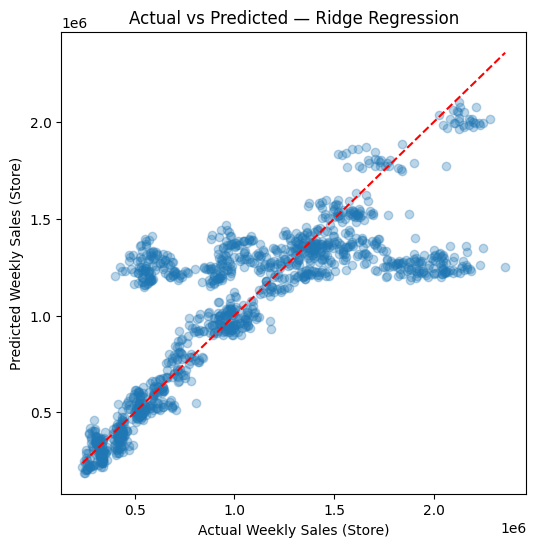

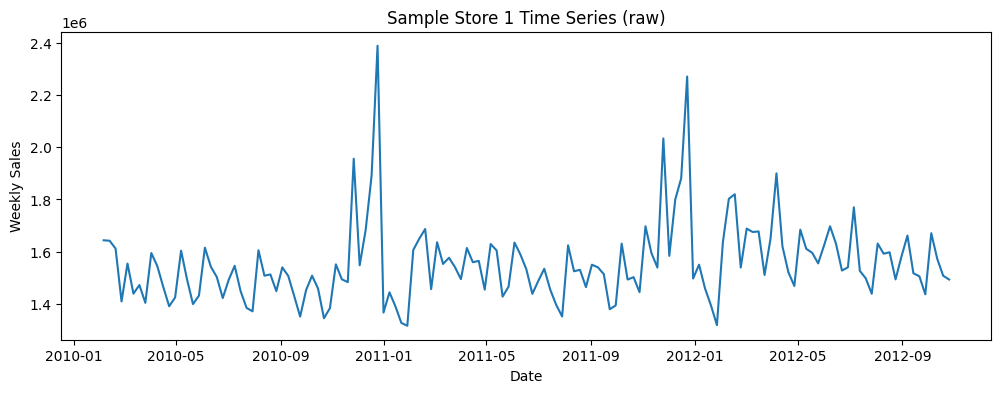

In [19]:
best = results_df.iloc[0]['Model']
print('Best model:', best)
y_pred_best = preds[best]

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Weekly Sales (Store)')
plt.ylabel('Predicted Weekly Sales (Store)')
plt.title(f'Actual vs Predicted — {best}')
plt.show()

# Show aggregate time-series for a sample store
sample_store = df['Store'].unique()[0]
sample_df = df[df['Store']==sample_store].groupby('Date')['Weekly_Sales'].sum().reset_index()
sample_df = sample_df.sort_values('Date')
plt.figure(figsize=(12,4))
plt.plot(sample_df['Date'], sample_df['Weekly_Sales'], label='Actual (store aggregated)')
plt.title(f'Sample Store {sample_store} Time Series (raw)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

## 9) Save models and scaler (optional)

In [20]:
joblib.dump(fitted, 'walmart_fitted_models.pkl')
joblib.dump(scaler, 'walmart_scaler.pkl')
print('Saved fitted models and scaler to files.')

Saved fitted models and scaler to files.


## Conclusion & Next steps

**Summary**
- We aggregated sales at the store-week level and engineered date features.
- Trained Linear, Ridge, Lasso, and Bayesian regression models and evaluated them using R², RMSE, and MAE.
- Visualized coefficients and inspected model predictions.

**Next steps / improvements**
- Use more advanced encoding for Store and Dept (target encoding, embeddings).
- Tune regularization strength (GridSearchCV) and validate with TimeSeriesSplit.
- Explore tree-based models (Random Forest, XGBoost) or deep learning for complex patterns.
- Create forecasting pipelines that handle future dates (lag features, rolling windows).

**How to run**
1. Place `Walmart.csv` in the notebook working directory or use Kaggle CLI to download.
2. Run all cells in order. If using Colab, upload `kaggle.json` to use the Kaggle CLI download cell.